# ASSIGNMENT 4                                                McGill COMP451 - Fall 2022
Student name (ID)

If you discussed solutions with any of your classmates please list their name here. If you used any external sources also acknowledge them here.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt 
from IPython.core.debugger import set_trace #this is used for debugging
np.random.seed(1234) 

## Problem 1. KNN (6 pts)

### 1a) Weighted KNN Classification (4pts)
In this assignment we want to implement a variation of kNN where we weight the classification vote of each point by the inverse of their distance to the test point. Fill in the code below to complete the implementation. 

In [2]:
#define the metric we will use to measure similarity
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class WeightedKNN:

    def __init__(self, K=3, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K #radius
        return
    
    def fit(self, x, y):
        self.x = x #store the training data using this method as it is a lazy learner
        self.y = y
        self.C = np.max(y) + 1 #number of classes
        return self
    
    def predict(self, x_test):
        ''' Makes a prediction using the stored training data and the test data given as argument'''
        n_test = x_test.shape[0]
        #next calculate the distance between every pair of training and test points (why?)
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:]) # n_test x n_train
        y_prob = np.zeros((n_test, self.C)) #keeps the probabilities for each class
        knns = np.zeros((n_test, self.K), dtype=int) # index of k nearest neighbours to each test point
        y_prob = np.zeros((n_test, self.C))  #ith-row of y_prob has the probability distribution over C classes
        # YOUR CODE HERE >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
        knns = distances.argsort(axis=1)[:, :self.K]
        neibour_classes = self.y[knns]
        for i in range(neibour_classes.shape[0]):
            for class_ in neibour_classes[i]:
                y_prob[i, class_] += 1
        # YOUR CODE HERE <<<<<<<<<<<<<<<<<<<<<<<<<<<<<< 
        return y_prob, knns

### 1.b.) classifying faces (2pts)
Next we use this method to classify face images. We use the *Olivetti face dataset*. The dataset contains 400 images of 40 people -- that is we have 10 images for each person. Each image is `64x64` and in black and white. Let us visualize some examples from the dataset.

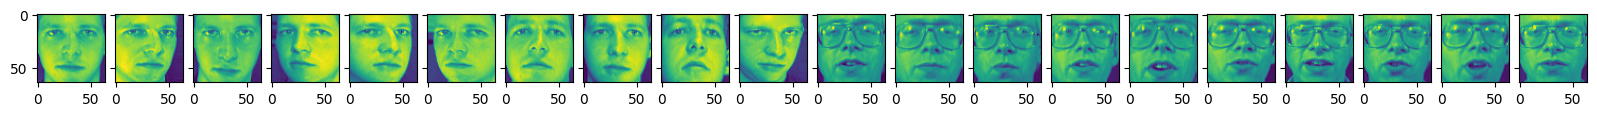

In [3]:
from sklearn import datasets 
from mpl_toolkits.axes_grid1 import ImageGrid                         #To plot the images in grid and we have seen it befoer 

x,y = datasets.fetch_olivetti_faces(return_X_y=True)
def plot_images(data):
    num_plots = data.shape[0]
    fig = plt.figure(figsize=(num_plots, 10.*num_plots))
    grid = ImageGrid(fig, 111, nrows_ncols=(1, num_plots), axes_pad=0.1)
    for i in range(num_plots):
        grid[i].imshow(data[i].reshape((64,64)))
    plt.show()
plot_images(x[:20]) 

Below, we plot the 10 nearest neighbours to the first face image above. We see that a few of closest neighbours can be used to classify the face image.

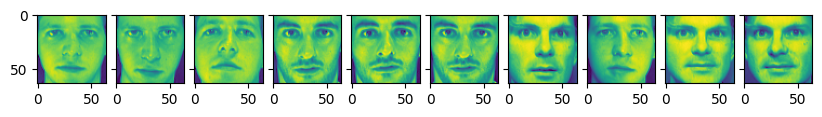

In [4]:
_, neighbours = WeightedKNN(K=10).fit(x,y).predict(x[[0]])
plot_images(x[neighbours[0]])

Shuffle the dataset and use 20% of the data for validation. Report the best hyper-parameter `K` using the validation set. You can use helper functions from `scikit-learn`.

In [5]:
# YOUR CODE HERE >>>>>>>>>>>>>>>>>>>>>>>
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm

train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.2, random_state=0)
best_k = 2
best_acc = 0.0
for k in tqdm([2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]):
    y_prob, neighbours = WeightedKNN(K=k).fit(train_x,train_y).predict(valid_x)
    preds = np.argmax(y_prob, axis=1)
    acc = accuracy_score(preds, valid_y)
    if acc > best_acc:
        best_acc = acc
        best_k = k
# YOUR CODE HERE <<<<<<<<<<<<<<<<<<<<<<<<
print(f'best validation accuracy is {best_acc*100} percent, using k={best_k}')

100%|███████████████████████████████████████████| 12/12 [00:03<00:00,  3.01it/s]

best validation accuracy is 88.75 percent, using k=2


## Problem 2. Principal Component Analysis (7 pts)

### 2.a.) Eigenfaces (2)
For this assignment, we will find the principle compomponents of the face dataset, these are the eigenvectors of the covariance matrix, and sometimes called *eigenfaces* for face datasets.
Perform PCA using SVD and plot the first 20 eigenfaces.

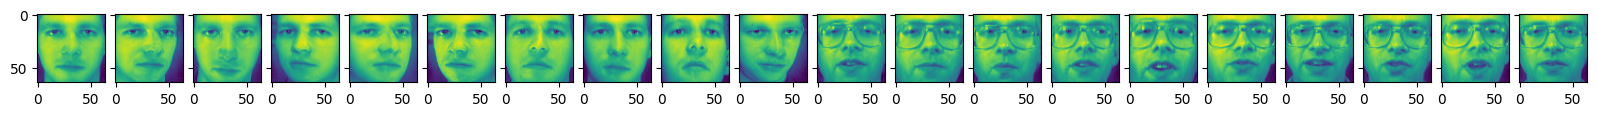

In [6]:
# YOUR CODE HERE >>>>>>>>>>>>>>>
mean_vector = x.mean(axis=0)
cov_mat = np.cov((x - mean_vector).T)
u, s, v = np.linalg.svd(cov_mat)
index_sort = s.argsort()[::-1]
eigenfaces = x.dot(u[:, index_sort]).dot(u[:, index_sort].T) + mean_vector
plot_images(eigenfaces[:20])
# YOUR CODE HERE <<<<<<<<<<<<<<

### 2.b) Picking the number of principal components (3 pts)
Plot the total amount variance explained versus the number of principal components.
Exactly how many principal components are needed to explain 95% of the variance in the data?

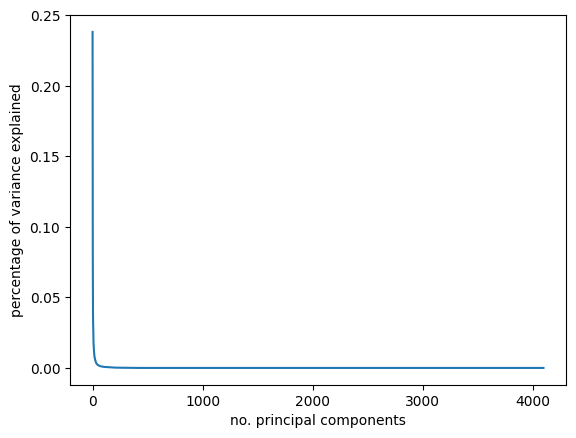

95% of the variance is explained using 124 principal components


In [7]:
# YOUR CODE HERE >>>>>>>>>>>>>>>>>
var_explained = s / s.sum()
L = 0
for i in range(var_explained.shape[0]):
    L = i
    if var_explained[:L].sum() >= 0.95:
        break
L += 1
# YOUR CODE HERE <<<<<<<<<<<<<<<<<
plt.plot(var_explained)
plt.xlabel("no. principal components")
plt.ylabel("percentage of variance explained")
plt.show()
print(f'95% of the variance is explained using {L} principal components')

### 2.C) Classification using embeddings (2pts)
Use the `WeightedKNN` of previous question to do classification in the embedding space. Use 100 principal components, and optimize for the choice of K in the range $K \in \{1,\ldots,10\}$. 
This means instead of storing the entire data, we can store its compressed form as vectors of length 100, while maintaining the accuracy. Note that the portion of the code that performs hyper-parameter tuning is identical to what you have above.

In [8]:
# YOUR CODE HERE >>>>>>>>>>>>>>>>>>>>
def pca_data(data, n):
    X = data.copy()
    mean_vector = X.mean(axis=0)
    cov_mat = np.cov((X - mean_vector).T)
    u, s, v = np.linalg.svd(cov_mat)
    index_sort = s.argsort()[-n:][::-1]
    eigenfaces = X.dot(u[:, index_sort])
    return eigenfaces

pca_x = pca_data(x, 100)
train_x, valid_x, train_y, valid_y = train_test_split(pca_x, y, test_size=0.2, random_state=0)
best_k = 2
best_acc = 0.0
for k in tqdm([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]):
    y_prob, neighbours = WeightedKNN(K=k).fit(train_x,train_y).predict(valid_x)
    preds = np.argmax(y_prob, axis=1)
    acc = accuracy_score(preds, valid_y)
    if acc > best_acc:
        best_acc = acc
        best_k = k
# YOUR CODE HERE <<<<<<<<<<<<<<<<<<
print(f'best validation accuracy is {best_acc*100} percent, using k={best_k}')

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 68.67it/s]

best validation accuracy is 95.0 percent, using k=1


## 3) K-Means clustering (7pts)
### 3a) Clustering faces (2pt)
Use the `KMeans` class from `scikit-learn` to cluster the data into K=40 clusters. Use other default values in the `scikit-learn` implementation. 
Plot the images for 5 out of 40 clusters. 

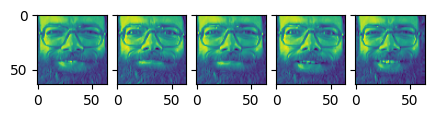

In [9]:
from sklearn import cluster
# YOUR CODE HERE >>>>>>>>>>>>>>>>>>>>>>>
model = cluster.KMeans(n_clusters=40)
model.fit(x, y)
y_cluster = model.predict(x)
images = x[np.where(y_cluster == 5)]
plot_images(images)
# YOUR CODE HERE <<<<<<<<<<<<<<<<<<<<<

### 3.b) Measuring clustering's agreement with true labels (5 pts)
You should see that clustering to some extend is able to identify class labels. However, they are not in complete agreement. Moreover, the order of clusters is completely arbitrary (i.e., cluster labels can be swapped with no change in the value of K-means objective). This means that two sets of labels are not directly comparable, and therefore a classification measure such as accuracy is not applicable.

Various *clustering agreement* measures exist that quantify the closeness of a clustering with a known ground truth. Two well-known measures are *Adjusted Rand Index (ARI)* and *Normalized Mutual Information (NMI)*. For this assignment we want to implement NMI to measure the agreement between different clustering techniques and the ground truth label in the face dataset above. Another motivation to implement NMI is because of its use of mutual information, and entropy. This would help familiarize you with practical implementation of these concepts.

If we assume that each clustering is giving a distribution over labels $p(Y), p'(Y')$, *mutual information* $\mathbb{I}(Y, Y') = \mathbb{D}_{KL}(p(Y,Y') \|| p(Y)p(Y'))$ between these distribution tells us how much one clustering tells us about the cluster labels produced by the alternative clustering. NMI then normalizes this value through division by the sum of entropies of $Y$ and $Y'$:
$$NMI(Y, Y') = \frac{2 \mathbb{I}(Y,Y')}{\mathbb{H}(Y) + \mathbb{H}(Y')}$$

Complete the implementation of NMI below. To test your implementation you can check against the impelementation of NMI in `scikit-learn`. A technical issue to have in mind is that when $p(Y=y) = 0$, $\log(p(y))$ evaluates to `Nan`. However, we know that, for example $p(y) \log p(y)$ should evaluate to zero in this case. To get around this problem we use `nansum` instead of `sum` when calculating quantities such as mutual information and entropy.
We can then compare the clustering to `spectral clustering` in terms of agreement with ground truth labels.

In [10]:
import warnings
warnings.filterwarnings('ignore')

def entropy(p):
    return -np.nansum(p * np.log(p)) 

def mutual_information(p_joint):
    # YOUR CODE HERE >>>>>>>>>>>>>>>>
    p_y, p_yp = np.sum(p_joint, 1), np.sum(p_joint, 0)
    mi = 0.0
    for i in range(p_y.shape[0]):
        for j in range(p_yp.shape[0]):
            term_a = p_joint[i, j]
            term_b = np.log(p_joint[i, j] / (p_y[i] * p_yp[j]))
            if np.abs(term_b) == np.inf or np.isnan(term_b):
                term_b = 0.0
            mi += term_a * term_b
    # YOUR CODE HERE <<<<<<<<<<<<<<<<   
    return mi

def nmi(y, yp):
    n = y.shape[0]
    c, cp = np.max(y)+1, np.max(yp)+1 #number of labels can be different for two clusterings
    p_joint = np.zeros((c, cp)) # joint distribution over labels
    # YOUR CODE HERE >>>>>>>>>>>>>>>>
    for i in range(y.shape[0]):
        p_joint[y[i], yp[i]] += 1 / y.shape[0]
    # YOUR CODE HERE <<<<<<<<<<<<<<<<   
    p_y, p_yp = np.sum(p_joint, 1), np.sum(p_joint, 0) #marginal distributions
    return 2*mutual_information(p_joint)/(entropy(p_y) + entropy(p_yp))

print(f'agreement between K-means labels and ground truth labels is {nmi(y, y_cluster)}')
y_cluster_spec = cluster.SpectralClustering(n_clusters=40).fit_predict(x)
print(f'agreement between spectral clustering labels and ground truth labels is {nmi(y, y_cluster_spec)}')

agreement between K-means labels and ground truth labels is 0.776335789431282
agreement between spectral clustering labels and ground truth labels is 0.4213998212677474
